# This Notebook Perform two things...........

# 1 Section:                                                                 
Research Area Subject Area Prediction (Large Scale classification) using shallow Multi-Layer Perceptron (MLP) model

# 2 Section:
Research Paper Recommendation for reading: using sentence transformer model

Research Papers dataset link::
https://www.kaggle.com/datasets/spsayakpaul/arxiv-paper-abstracts/data


# 1 Section:                                                                 

# Loading tools and dataset

In [42]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split

from ast import literal_eval
# is used for safely evaluating strings containing Python literals or container displays
# (e.g., lists, dictionaries) to their corresponding Python objects.

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [43]:
arxiv_data = pd.read_csv("arxiv_data_210930-054931.csv")

In [44]:
arxiv_data.head()

,terms,titles,abstracts
0,['cs.LG'],Multi-Level Attention Pooling for Graph Neural Networks: Unifying Graph Representations with Multiple Localities,"Graph neural networks (GNNs) have been widely used to learn vector\nrepresentation of graph-structured data and achieved better task performance\nthan conventional methods. The foundation of GNNs is the message passing\nprocedure, which propagates the information in a node to its neighbors. Since\nthis procedure proceeds one step per layer, the range of the information\npropagation among nodes is small in the lower layers, and it expands toward the\nhigher layers. Therefore, a GNN model has to be deep enough to capture global\nstructural information in a graph. On the other hand, it is known that deep GNN\nmodels suffer from performance degradation because they lose nodes' local\ninformation, which would be essential for good model performance, through many\nmessage passing steps. In this study, we propose multi-level attention pooling\n(MLAP) for graph-level classification tasks, which can adapt to both local and\nglobal structural information in a graph. It has an attention pooling layer for\neach message passing step and computes the final graph representation by\nunifying the layer-wise graph representations. The MLAP architecture allows\nmodels to utilize the structural information of graphs with multiple levels of\nlocalities because it preserves layer-wise information before losing them due\nto oversmoothing. Results of our experiments show that the MLAP architecture\nimproves the graph classification performance compared to the baseline\narchitectures. In addition, analyses on the layer-wise graph representations\nsuggest that aggregating information from multiple levels of localities indeed\nhas the potential to improve the discriminability of learned graph\nrepresentations."
1,"['cs.LG', 'cs.AI']",Decision Forests vs. Deep Networks: Conceptual Similarities and Empirical Differences at Small Sample Sizes,"Deep networks and decision forests (such as random forests and gradient\nboosted trees) are the leading machine learning methods for structured and\ntabular data, respectively. Many papers have empirically compared large numbers\nof classifiers on one or two different domains (e.g., on 100 different tabular\ndata settings). However, a careful conceptual and empirical comparison of these\ntwo strategies using the most contemporary best practices has yet to be\nperformed. Conceptually, we illustrate that both can be profitably viewed as\n""partition and vote"" schemes. Specifically, the representation space that they\nboth learn is a partitioning of feature space into a union of convex polytopes.\nFor inference, each decides on the basis of votes from the activated nodes.\nThis formulation allows for a unified basic understanding of the relationship\nbetween these methods. Empirically, we compare these two strategies on hundreds\nof tabular data settings, as well as several vision and auditory settings. Our\nfocus is on datasets with at most 10,000 samples, which represent a large\nfraction of scientific and biomedical datasets. In general, we found forests to\nexcel at tabular and structured data (vision and audition) with small sample\nsizes, whereas deep nets performed better on structured data with larger sample\nsizes. This suggests that further gains in both scenarios may be realized via\nfurther combining aspects of forests and networks. We will continue revising\nthis technical report in the coming months with updated results."
2,"['cs.LG', 'cs.CR', 'stat.ML']",Power up! Robust Graph Convolutional Network via Graph Powering,"Graph convolutional networks (GCNs) are powerful tools for graph-structured\ndata. However, they have been recently shown to be vulnerable to topological\nattacks. To enhance adversarial robustness, we go beyond spectral graph theory\nto robust graph theory. By challenging the classical graph Laplacian, we\npropose a new convolution operator t

# Data Cleaning and Preprocessing

In [45]:
arxiv_data.shape

(56181, 3)

In [46]:
arxiv_data.isnull().sum()

terms        0
titles       0
abstracts    0
dtype: int64

In [47]:
arxiv_data.duplicated().sum()

15054

In [48]:
# getting unique labels
labels_column = arxiv_data['terms'].apply(literal_eval)
labels = labels_column.explode().unique()
print("labels :",labels)
print("lenght :",len(labels))

labels : ['cs.LG' 'cs.AI' 'cs.CR' ... 'D.1.3; G.4; I.2.8; I.2.11; I.5.3; J.3'
 '68T07, 68T45, 68T10, 68T50, 68U35' 'I.2.0; G.3']
lenght : 1177


In [49]:
arxiv_data = arxiv_data[~arxiv_data['titles'].duplicated()]

In [79]:
arxiv_data.shape

(41105, 1)

In [50]:
# remove duplicate entries based on the "titles" (terms) column
# This filters the DataFrame, keeping only the rows where the titles are not duplicated.

print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")
# There are some terms with occurrence as low as 1.
print(sum(arxiv_data['terms'].value_counts()==1))
# how many unique terms
print(arxiv_data['terms'].nunique())

There are 41105 rows in the deduplicated dataset.
2503
3401


In [51]:
# Filtering the rare terms. (it keeps only those rows where the "terms" value occurs more than once in the original DataFrame.)
arxiv_data_filtered = arxiv_data.groupby('terms').filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(38602, 3)

In [52]:
# It evaluates the given string containing a Python literal or container display (e.g., a list or dictionary) and returns the corresponding Python object.
arxiv_data_filtered['terms'] = arxiv_data_filtered['terms'].apply(lambda x: literal_eval(x))
arxiv_data_filtered['terms'].values[:3]

array([list(['cs.LG']), list(['cs.LG', 'cs.AI']),
       list(['cs.LG', 'cs.CR', 'stat.ML'])], dtype=object)

# train and test split.

In [53]:
test_split = 0.1

# Initial train and test split.
# The stratify parameter ensures that the splitting is done in a way that preserves the same distribution of labels (terms) in both the training and test sets.
train_df, test_df = train_test_split(arxiv_data_filtered,test_size=test_split,stratify=arxiv_data_filtered["terms"].values,)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 34741
Number of rows in validation set: 1930
Number of rows in test set: 1931


In [54]:
# creates a TensorFlow RaggedTensor (terms) from the values in the "terms" column of the train_df DataFrame. A RaggedTensor is a tensor with non-uniform shapes
terms = tf.ragged.constant(train_df['terms'].values)
# This line creates a StringLookup layer in TensorFlow. The purpose of this layer is to map strings to integer indices and vice versa. The output_mode="multi_hot" indicates that the layer will output a multi-hot encoded representation of the input strings.
lookup = tf.keras.layers.StringLookup(output_mode='multi_hot')
# This step adapts the StringLookup layer to the unique values in the "terms" column, building the vocabulary.
lookup.adapt(terms)
# retrieve vocabulary
vocab = lookup.get_vocabulary()

print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.GR', 'cs.CR', 'math.OC', 'eess.SP', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'eess.SY', 'cs.MA', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'stat.AP', 'cs.CY', 'stat.ME', 'stat.TH', 'math.ST', 'eess.AS', 'cs.SD', 'cs.DS', 'q-bio.QM', 'q-bio.NC', 'cs.CG', 'stat.CO', 'cs.NI', 'cs.GT', 'math.NA', 'cs.SE', 'cs.NA', 'I.2.6', 'physics.chem-ph', 'cs.DB', 'physics.comp-ph', 'cond-mat.dis-nn', 'q-bio.BM', 'cs.LO', 'math.PR', 'cs.PL', '68T45', 'cs.AR', 'physics.data-an', 'quant-ph', 'I.2.10', 'cs.CE', 'cond-mat.stat-mech', 'q-fin.ST', 'physics.ao-ph', 'math.DS', 'I.4.6', 'cs.CC', '68T05', 'physics.soc-ph', 'physics.med-ph', 'cs.PF', 'cs.DM', 'econ.EM', 'I.4.8', 'q-bio.GN', 'astro-ph.IM', 'physics.flu-dyn', 'math.AT', 'hep-ex', 'I.4', '68U10', 'q-fin.TR', 'physics.geo-ph', 'cs.FL', 'I.5.4', 'I.2', 'physics.optics', 'cond-mat.mtrl-sci', 'I.4.9', '68T10', 'I.4; I.5', '68T07', 'q-fin.CP', 'math.CO', 'math.AP

In [80]:
train_df['terms']

1756                            [cs.CV]
12167           [cs.LG, cs.AI, stat.ML]
6095               [cs.CV, astro-ph.IM]
24751             [cs.LG, cs.CV, cs.NE]
4605                   [stat.ML, cs.LG]
                      ...              
20241                           [cs.CV]
7153                            [cs.LG]
1621                            [cs.CV]
12684                    [cs.CV, cs.LG]
15646    [stat.ML, cs.CV, cs.LG, cs.NE]
Name: terms, Length: 34741, dtype: object

In [55]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['cs.CV']
Label-binarized representation: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [56]:
# following lines::
# which is used for automatic adjustment of resource usage by TensorFlow's data loading pipeline.

#max_seqlen: Maximum sequence length. It indicates the maximum length allowed for sequences.
max_seqlen = 150
#batch_size: Batch size. It specifies the number of samples to use in each iteration.
batch_size = 128
#padding_token: A token used for padding sequences.
padding_token = "<pad>"
#auto = tf.data.AUTOTUNE: auto is assigned the value tf.data.AUTOTUNE,
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    # creating sequences of labesls
    labels = tf.ragged.constant(dataframe["terms"].values)
    #This line uses the previously defined lookup layer to convert the ragged tensor of labels into a binarized representation. The resulting label_binarized is a NumPy array.
    label_binarized = lookup(labels).numpy()
    # creating sequences of text.
    dataset = tf.data.Dataset.from_tensor_slices((dataframe["abstracts"].values, label_binarized))
    # shuffling data basis on condition
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

"""
In summary, the make_dataset function is designed to create a 
dataset suitable for training a model. It takes a dataframe as input, 
assumes it has "abstracts" and "terms" columns, and creates a dataset of 
batches where each batch consists of abstract 
sequences and their corresponding binarized label sequences. 
"""

'\nIn summary, the make_dataset function is designed to create a \ndataset suitable for training a model. It takes a dataframe as input, \nassumes it has "abstracts" and "terms" columns, and creates a dataset of \nbatches where each batch consists of abstract \nsequences and their corresponding binarized label sequences. \n'

In [81]:
text_batch,label_batch = next(iter(train_dataset))
for i,text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None,...]
    print(text)
    print(label)

tf.Tensor(b'Homographies -- a mathematical formalism for relating image points across\ndifferent camera viewpoints -- are at the foundations of geometric methods in\ncomputer vision and are used in geometric camera calibration, image\nregistration, and stereo vision and other tasks. In this paper, we show the\nsurprising result that colors across a change in viewing condition (changing\nlight color, shading and camera) are also related by a homography. We propose a\nnew color correction method based on color homography. Experiments demonstrate\nthat solving the color homography problem leads to more accurate calibration.', shape=(), dtype=string)
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [57]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [86]:
def invert_multi_hot(encoded_labels):
    hot_indeces = np.argwhere(encoded_labels==1.0)[...,0]
    return np.take(vocab,hot_indeces)



# This code snippet is iterating through batches of the training dataset and printing the abstract text along with the corresponding labels.
text_batch, label_batch = next(iter(train_dataset))
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(text)
    print(invert_multi_hot(label))
   

tf.Tensor(b'Convolutional neural network (CNN) have proven its success for semantic\nsegmentation, which is a core task of emerging industrial applications such as\nautonomous driving. However, most progress in semantic segmentation of urban\nscenes is reported on standard scenarios, i.e., daytime scenes with favorable\nillumination conditions. In practical applications, the outdoor weather and\nillumination are changeable, e.g., cloudy and nighttime, which results in a\nsignificant drop of semantic segmentation accuracy of CNN only trained with\ndaytime data. In this paper, we propose a novel generative adversarial network\n(namely Mutual-GAN) to alleviate the accuracy decline when daytime-trained\nneural network is applied to videos captured under adverse weather conditions.\nThe proposed Mutual-GAN adopts mutual information constraint to preserve\nimage-objects during cross-weather adaptation, which is an unsolved problem for\nmost unsupervised image-to-image translation approaches 

In [87]:
# This code calculates the size of the vocabulary in the "abstracts" column of the train_df DataFrame.

# Creating vocabulary with uniques words
vocabulary = set()
train_df["abstracts"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

158986


# Text Vectorization

In [88]:
# Initializes a TextVectorization layer
text_vectorizer = layers.TextVectorization(max_tokens=vocabulary_size,ngrams=2,output_mode="tf_idf")
# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

In [89]:
"""
Mapping Vectorization to Datasets: The code maps the text vectorization operation to 
each element of the training, validation, and test datasets. This ensures that the text
data in each dataset is transformed into numerical vectors using the adapted TextVectorization layer.
The num_parallel_calls parameter is used to parallelize the mapping process, and prefetch is 
applied to prefetch data batches 
for better performance.
"""
train_dataset = train_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
validation_dataset = validation_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
test_dataset = test_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)

# model training

In [90]:
# creating shallow_mlp_model  (MLP)
from tensorflow.keras.callbacks import EarlyStopping

# Creating shallow_mlp_model (MLP) with dropout layers
model1 = keras.Sequential([
    # First hidden layer: 512 neurons, ReLU activation function, with dropout.
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),  # Adding dropout for regularization.

    # Second hidden layer: 256 neurons, ReLU activation function, with dropout.
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),  # Adding dropout for regularization.

    # Output layer: The number of neurons equals the vocabulary size (output vocabulary of the StringLookup layer), with a sigmoid activation function.
    layers.Dense(lookup.vocabulary_size(), activation='sigmoid')
])

# Compile the model
model1.compile(loss="binary_crossentropy", optimizer='adam', metrics=['binary_accuracy'])

# Add early stopping
# Number of epochs with no improvement after which training will be stopped.
# Restore weights from the epoch with the best value of the monitored quantity.
early_stopping = EarlyStopping(patience=5,restore_best_weights=True)

# Train the model
# Add early stopping callback.verbose=1
history = model1.fit(train_dataset,validation_data=validation_dataset,epochs=20,callbacks=[early_stopping])

Epoch 1/20
272/272 [==============================] - 207s 754ms/step - loss: 0.0489 - binary_accuracy: 0.9831 - val_loss: 0.0183 - val_binary_accuracy: 0.9947
Epoch 2/20
272/272 [==============================] - 210s 769ms/step - loss: 0.0175 - binary_accuracy: 0.9950 - val_loss: 0.0179 - val_binary_accuracy: 0.9947
Epoch 3/20
272/272 [==============================] - 199s 729ms/step - loss: 0.0137 - binary_accuracy: 0.9959 - val_loss: 0.0185 - val_binary_accuracy: 0.9946
Epoch 4/20
272/272 [==============================] - 198s 727ms/step - loss: 0.0113 - binary_accuracy: 0.9966 - val_loss: 0.0192 - val_binary_accuracy: 0.9947
Epoch 5/20
272/272 [==============================] - 197s 723ms/step - loss: 0.0098 - binary_accuracy: 0.9971 - val_loss: 0.0203 - val_binary_accuracy: 0.9946
Epoch 6/20
272/272 [==============================] - 183s 671ms/step - loss: 0.0086 - binary_accuracy: 0.9975 - val_loss: 0.0198 - val_binary_accuracy: 0.9945
Epoch 7/20
272/272 [====================

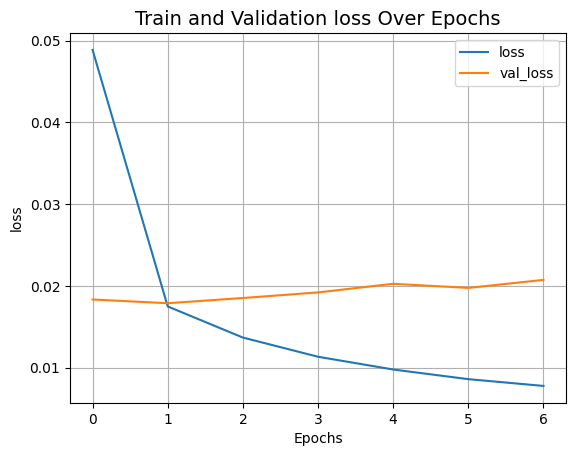

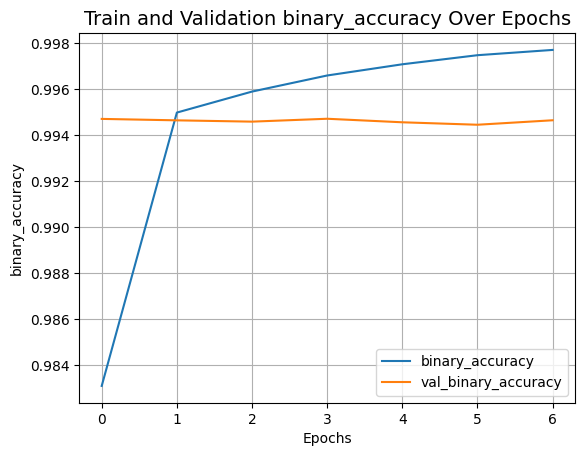

In [91]:
# plotting loss
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

# Model Evaluation

In [92]:
# model evaltuation on test and val dataset
_, binary_acc1 = model1.evaluate(test_dataset)
_, binary_acc2 = model1.evaluate(validation_dataset)

print(f"Categorical accuracy on the test set: {round(binary_acc1 * 100, 2)}%.")
print(f"Categorical accuracy on the validation set: {round(binary_acc2 * 100, 2)}%.")

16/16 [==============================] - 2s 114ms/step - loss: 0.0179 - binary_accuracy: 0.9947
Categorical accuracy on the test set: 99.46%.
Categorical accuracy on the validation set: 99.47%.


# Save Model and Text Vectorizer:

In [97]:
# Save the model
model1.save("models/model.h5")

# Save the configuration of the text vectorizer
saved_text_vectorizer_config = text_vectorizer.get_config()
with open("models/text_vectorizer_config.pkl", "wb") as f:
    pickle.dump(saved_text_vectorizer_config, f)


# Save the vocabulary
with open("models/vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)

# Load Model and Text Vectorizer:

In [108]:
from tensorflow import keras
import pickle

# Load the model
loaded_model = keras.models.load_model("models/model.h5")

from tensorflow.keras.layers import TextVectorization

# Load the configuration of the text vectorizer
with open("models/text_vectorizer_config.pkl", "rb") as f:
    saved_text_vectorizer_config = pickle.load(f)

# Create a new TextVectorization layer with the saved configuration
loaded_text_vectorizer = TextVectorization.from_config(saved_text_vectorizer_config)

# Load the saved weights into the new TextVectorization layer
with open("models/text_vectorizer_weights.pkl", "rb") as f:
    weights = pickle.load(f)
    loaded_text_vectorizer.set_weights(weights)


In [109]:
# Load the vocabulary
with open("models/vocab.pkl", "rb") as f:
    loaded_vocab = pickle.load(f)


# Model Prediction

In [110]:
def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(loaded_vocab, hot_indices)

In [111]:
def predict_category(abstract, model, vectorizer, label_lookup):
    # Preprocess the abstract using the loaded text vectorizer
    preprocessed_abstract = vectorizer([abstract])

    # Make predictions using the loaded model
    predictions = model.predict(preprocessed_abstract)

    # Convert predictions to human-readable labels
    predicted_labels = label_lookup(np.round(predictions).astype(int)[0])

    return predicted_labels

In [112]:
# Example usage
new_abstract = "Graph neural networks (GNNs) have been widely used to learn vector\nrepresentation of graph-structured data and achieved better task performance\nthan conventional methods. The foundation of GNNs is the message passing\nprocedure, which propagates the information in a node to its neighbors. Since\nthis procedure proceeds one step per layer, the range of the information\npropagation among nodes is small in the lower layers, and it expands toward the\nhigher layers. Therefore, a GNN model has to be deep enough to capture global\nstructural information in a graph. On the other hand, it is known that deep GNN\nmodels suffer from performance degradation because they lose nodes' local\ninformation, which would be essential for good model performance, through many\nmessage passing steps. In this study, we propose multi-level attention pooling\n(MLAP) for graph-level classification tasks, which can adapt to both local and\nglobal structural information in a graph. It has an attention pooling layer for\neach message passing step and computes the final graph representation by\nunifying the layer-wise graph representations. The MLAP architecture allows\nmodels to utilize the structural information of graphs with multiple levels of\nlocalities because it preserves layer-wise information before losing them due\nto oversmoothing. Results of our experiments show that the MLAP architecture\nimproves the graph classification performance compared to the baseline\narchitectures. In addition, analyses on the layer-wise graph representations\nsuggest that aggregating information from multiple levels of localities indeed\nhas the potential to improve the discriminability of learned graph\nrepresentations."
predicted_categories = predict_category(new_abstract, loaded_model, loaded_text_vectorizer, invert_multi_hot)
print("Predicted Categories:", predicted_categories)


1/1 [==============================] - 0s 336ms/step
Predicted Categories: ['cs.LG']


In [113]:
# Example usage
new_abstract = 'Deep networks and decision forests (such as random forests and gradient\nboosted trees) are the leading machine learning methods for structured and\ntabular data, respectively. Many papers have empirically compared large numbers\nof classifiers on one or two different domains (e.g., on 100 different tabular\ndata settings). However, a careful conceptual and empirical comparison of these\ntwo strategies using the most contemporary best practices has yet to be\nperformed. Conceptually, we illustrate that both can be profitably viewed as\n"partition and vote" schemes. Specifically, the representation space that they\nboth learn is a partitioning of feature space into a union of convex polytopes.\nFor inference, each decides on the basis of votes from the activated nodes.\nThis formulation allows for a unified basic understanding of the relationship\nbetween these methods. Empirically, we compare these two strategies on hundreds\nof tabular data settings, as well as several vision and auditory settings. Our\nfocus is on datasets with at most 10,000 samples, which represent a large\nfraction of scientific and biomedical datasets. In general, we found forests to\nexcel at tabular and structured data (vision and audition) with small sample\nsizes, whereas deep nets performed better on structured data with larger sample\nsizes. This suggests that further gains in both scenarios may be realized via\nfurther combining aspects of forests and networks. We will continue revising\nthis technical report in the coming months with updated results.'
predicted_categories = predict_category(new_abstract, loaded_model, loaded_text_vectorizer, invert_multi_hot)
print("Predicted Categories:", predicted_categories)

1/1 [==============================] - 0s 33ms/step
Predicted Categories: ['cs.LG' 'stat.ML']


In [114]:
# great resutls...................................

# =======Section 2========

# 2 Recommendation System

In [59]:
# Check if the columns exist before dropping
if 'terms' in arxiv_data.columns and 'abstracts' in arxiv_data.columns:
    arxiv_data.drop(columns=['terms', 'abstracts'], inplace=True)
else:
    print("Columns 'terms' and/or 'abstracts' are not present in the DataFrame.")

arxiv_data

,titles
0,Multi-Level Attention Pooling for Graph Neural Networks: Unifying Graph Representations with Multiple Localities
1,Decision Forests vs. Deep Networks: Conceptual Similarities and Empirical Differences at Small Sample Sizes
2,Power up! Robust Graph Convolutional Network via Graph Powering
3,Releasing Graph Neural Networks with Differential Privacy Guarantees
4,Recurrence-Aware Long-Term Cognitive Network for Explainable Pattern Classification
...,...
56173,An experimental study of graph-based semi-supervised classification with additional node information
56175,Bayesian Differential Privacy through Posterior Sampling
56176,Mining Spatio-temporal Data on Industrialization from Historical Registries
56177,Wav2Letter: an End-to-End ConvNet-based Speech Recognition System


In [60]:
arxiv_data.drop_duplicates(inplace= True)
arxiv_data.reset_index(drop= True,inplace = True)

In [61]:
pd.set_option('display.max_colwidth', None)
arxiv_data

,titles
0,Multi-Level Attention Pooling for Graph Neural Networks: Unifying Graph Representations with Multiple Localities
1,Decision Forests vs. Deep Networks: Conceptual Similarities and Empirical Differences at Small Sample Sizes
2,Power up! Robust Graph Convolutional Network via Graph Powering
3,Releasing Graph Neural Networks with Differential Privacy Guarantees
4,Recurrence-Aware Long-Term Cognitive Network for Explainable Pattern Classification
...,...
41100,An experimental study of graph-based semi-supervised classification with additional node information
41101,Bayesian Differential Privacy through Posterior Sampling
41102,Mining Spatio-temporal Data on Industrialization from Historical Registries
41103,Wav2Letter: an End-to-End ConvNet-based Speech Recognition System


# Sentence Transformers

In [62]:
# !pip install -U -q sentence-transformers

In [63]:
# This imports the SentenceTransformer class from the Sentence Transformers library.
from sentence_transformers import SentenceTransformer, util


In [64]:
model = SentenceTransformer('all-MiniLM-L6-v2')


In [65]:
sentences = arxiv_data['titles']

In [66]:
embeddings = model.encode(sentences)

In [67]:
embeddings.shape

(41105, 384)

In [68]:
embeddings

array([[ 0.06643401, -0.04954599,  0.06388084, ...,  0.00106301,
        -0.12156387, -0.06962775],
       [ 0.09212255, -0.07606939,  0.06572868, ..., -0.08565173,
        -0.09266546,  0.00725291],
       [-0.08162684,  0.02428939,  0.01888745, ...,  0.0080616 ,
        -0.05129535, -0.05873999],
       ...,
       [ 0.01227974, -0.08568835, -0.02782772, ..., -0.0525797 ,
        -0.1080669 ,  0.0784331 ],
       [-0.07258197, -0.12690917, -0.00535544, ...,  0.03597707,
        -0.03986151, -0.05971035],
       [ 0.00768869, -0.10124185,  0.08909851, ..., -0.08199873,
        -0.05649745,  0.09007051]], dtype=float32)

# Why select all-MiniLM-L6-v2?

All-round model tuned for many use-cases. Trained on a large and diverse dataset of over 1 billion training pairs. Source

Its small in size 80 MB with good performance.

# Print the embeddings

In [69]:
c = 0
#This loop iterates over pairs of sentences and their corresponding embeddings. 
#zip is used to iterate over both lists simultaneously.
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding length:", len(embedding)) # list of floats
    print("")
    # Breaks out of the loop after printing information for the first 5 sentences.
    if c >=5:
        break
    c +=1 

Sentence: Multi-Level Attention Pooling for Graph Neural Networks: Unifying Graph Representations with Multiple Localities
Embedding length: 384

Sentence: Decision Forests vs. Deep Networks: Conceptual Similarities and Empirical Differences at Small Sample Sizes
Embedding length: 384

Sentence: Power up! Robust Graph Convolutional Network via Graph Powering
Embedding length: 384

Sentence: Releasing Graph Neural Networks with Differential Privacy Guarantees
Embedding length: 384

Sentence: Recurrence-Aware Long-Term Cognitive Network for Explainable Pattern Classification
Embedding length: 384

Sentence: Lifelong Graph Learning
Embedding length: 384



# Save files

In [70]:
import pickle
# Saving sentences and corresponding embeddings
with open('/Users/shree/research paper/Research-Papers-Recommendation-System-and-Subject-Area-Prediction-Using-Deep-Learning-and-LLMS/embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

with open('/Users/shree/research paper/Research-Papers-Recommendation-System-and-Subject-Area-Prediction-Using-Deep-Learning-and-LLMS/sentences.pkl', 'wb') as f:
    pickle.dump(sentences, f)
    
with open('/Users/shree/research paper/Research-Papers-Recommendation-System-and-Subject-Area-Prediction-Using-Deep-Learning-and-LLMS/rec_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Recommendation for similar papers

In [71]:
# load save files
embeddings = pickle.load(open('models/embeddings.pkl','rb'))
sentences = pickle.load(open('models/sentences.pkl','rb'))
rec_model = pickle.load(open('models/rec_model.pkl','rb'))

In [72]:
import torch

def recommendation(input_paper):
    # Calculate cosine similarity scores between the embeddings of input_paper and all papers in the dataset.
    cosine_scores = util.cos_sim(embeddings, rec_model.encode(input_paper))
    
    # Get the indices of the top-k most similar papers based on cosine similarity.
    top_similar_papers = torch.topk(cosine_scores, dim=0, k=5, sorted=True)
                                 
    # Retrieve the titles of the top similar papers.
    papers_list = []
    for i in top_similar_papers.indices:
        papers_list.append(sentences[i.item()])
    
    return papers_list


In [73]:
# exampel usage 1: (use this paper as input (Attention is All you Need))
input_paper = input("Enter the title of any paper you like")
recommend_papers = recommendation(input_paper)


print("We recommend to read this paper............")
print("=============================================")
for paper in recommend_papers:
    print(paper)

We recommend to read this paper............
Persuasive Faces: Generating Faces in Advertisements
Copy this Sentence
Area Attention
"You eat with your eyes first": Optimizing Yelp Image Advertising
AiAds: Automated and Intelligent Advertising System for Sponsored Search


In [74]:
# exampel usage 2: (use this paper as input (BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding))
input_paper = input("Enter the title of any paper you like")
recommend_papers = recommendation(input_paper)


print("We recommend to read this paper............")
print("=============================================")
for paper in recommend_papers:
    print(paper)

We recommend to read this paper............
Persuasive Faces: Generating Faces in Advertisements
Copy this Sentence
Area Attention
"You eat with your eyes first": Optimizing Yelp Image Advertising
AiAds: Automated and Intelligent Advertising System for Sponsored Search


In [75]:
# exampel usage 3: (use this paper as input (Review of deep learning: concepts, CNN architectures, challenges, applications, future directions))
input_paper = input("Enter the title of any paper you like")
recommend_papers = recommendation(input_paper)


print("We recommend to read this paper............")
print("=============================================")
for paper in recommend_papers:
    print(paper)

We recommend to read this paper............
Persuasive Faces: Generating Faces in Advertisements
Copy this Sentence
Area Attention
"You eat with your eyes first": Optimizing Yelp Image Advertising
AiAds: Automated and Intelligent Advertising System for Sponsored Search


In [76]:
# install this versions
import sentence_transformers
import tensorflow
import torch
print(torch.__version__)
print(sentence_transformers.__version__)
print(tensorflow.__version__)

2.7.0
4.1.0
2.15.0
